In [1]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from matplotlib import patches

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import Compose, ToTensor, Resize

from os.path import join, isdir
from os import listdir, mkdir
from shutil import copyfile, move

import json
from tqdm import tqdm

np.random.seed(42)

In [2]:
path = '/home/egor/job/CAPTCHA_recognition/data/captchas_fns'

# Data loading

Manually labeled data

In [3]:
df = pd.read_csv(join(path, 'captchas_labeled', 'labels.csv'))

In [4]:
df.head()

,#filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,0.png,1502,{},6,0,"{""name"":""rect"",""x"":30,""y"":26,""width"":31,""heigh...","{""label"":""1""}"
1,0.png,1502,{},6,1,"{""name"":""rect"",""x"":57,""y"":29,""width"":24,""heigh...","{""label"":""4""}"
2,0.png,1502,{},6,2,"{""name"":""rect"",""x"":78,""y"":29,""width"":25,""heigh...","{""label"":""9""}"
3,0.png,1502,{},6,3,"{""name"":""rect"",""x"":98,""y"":25,""width"":35,""heigh...","{""label"":""9""}"
4,0.png,1502,{},6,4,"{""name"":""rect"",""x"":127,""y"":22,""width"":33,""heig...","{""label"":""5""}"


In [5]:
proc_df = pd.DataFrame()

proc_df['cord_dict'] = df['region_shape_attributes'].apply(lambda x: json.loads(x))

proc_df['img_name'] = df['#filename']
proc_df['region_id'] = df['region_id']
proc_df['x0'] = proc_df['cord_dict'].apply(lambda x: x['x'])
proc_df['y0'] = proc_df['cord_dict'].apply(lambda x: x['y'])
proc_df['x1'] = proc_df.apply(lambda row: row['x0'] + row['cord_dict']['width'], axis=1)
proc_df['y1'] = proc_df.apply(lambda row: row['y0'] + row['cord_dict']['height'], axis=1)
proc_df['w'] = proc_df['cord_dict'].apply(lambda x: x['width'])
proc_df['h'] = proc_df['cord_dict'].apply(lambda x: x['height'])
proc_df['label'] = df['region_attributes'].apply(lambda x: json.loads(x)['label'])

proc_df = proc_df.drop(['cord_dict'], axis=1)

proc_df.head()

,img_name,region_id,x0,y0,x1,y1,w,h,label
0,0.png,0,30,26,61,71,31,45,1
1,0.png,1,57,29,81,73,24,44,4
2,0.png,2,78,29,103,72,25,43,9
3,0.png,3,98,25,133,71,35,46,9
4,0.png,4,127,22,160,73,33,51,5


In [6]:
proc_df['img_name'].nunique()

193

Auto labeled data

In [7]:
df2 = pd.read_csv(join(path, 'captchas_labeled', 'auto_labeled_labels.csv'))

In [8]:
df2.head()

,img_name,region_id,x0,y0,x1,y1,w,h,label
0,5814.png,0,49,30,92,78,43,48,9
1,5814.png,1,128,27,155,77,27,50,5
2,5814.png,2,101,31,133,76,32,45,2
3,5814.png,3,30,32,54,81,24,49,1
4,5814.png,4,83,32,108,71,25,39,7


In [9]:
df2['img_name'].nunique()

126

Combine data

In [10]:
proc_df = pd.concat([proc_df, df2], axis=0)
proc_df.head()

,img_name,region_id,x0,y0,x1,y1,w,h,label
0,0.png,0,30,26,61,71,31,45,1
1,0.png,1,57,29,81,73,24,44,4
2,0.png,2,78,29,103,72,25,43,9
3,0.png,3,98,25,133,71,35,46,9
4,0.png,4,127,22,160,73,33,51,5


In [11]:
proc_df['img_name'].nunique()

319

In [12]:
proc_df['label'] = proc_df['label'].apply(lambda x: str(x))

Distribution of numbers

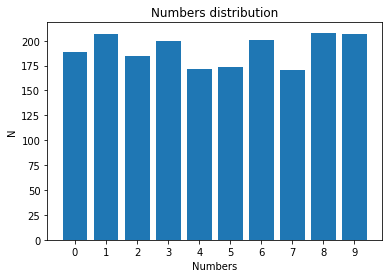

In [13]:
num_freq = proc_df['label'].value_counts()
num_freq = [(k, v) for k, v in zip(num_freq.keys(), num_freq.values)]
num_freq = sorted(num_freq, key=lambda x: x[0])

plt.bar(range(len(num_freq)), [i[1] for i in num_freq], align='center')
plt.xticks(range(len(num_freq)), [i[0] for i in num_freq])
plt.xlabel('Numbers')
plt.ylabel('N')
plt.title('Numbers distribution')
plt.show()

# Deep learning

## Data handling

In [14]:
np.random.seed(42)

if not isdir(join(path, 'train')):
    mkdir(join(path, 'train'))
if not isdir(join(path, 'val')):
    mkdir(join(path, 'val'))
    
img_names = [name for name in listdir(join(path, 'captchas_labeled')) if '.png' in name]

n_train = int(0.85 * len(img_names))
indices = np.random.permutation(len(img_names))
img_names = [img_names[i] for i in indices]

train_images = img_names[:n_train]
val_images = img_names[n_train:]

for name in train_images:
    copyfile(join(path, 'captchas_labeled', name), join(path, 'train', name))

for name in val_images:
    copyfile(join(path, 'captchas_labeled', name), join(path, 'val', name))
    
train_df = proc_df[proc_df['img_name'].isin(train_images)]
val_df = proc_df[proc_df['img_name'].isin(val_images)]

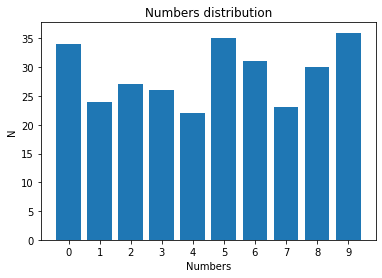

In [15]:
num_freq = val_df['label'].value_counts()
num_freq = [(k, v) for k, v in zip(num_freq.keys(), num_freq.values)]
num_freq = sorted(num_freq, key=lambda x: x[0])

plt.bar(range(len(num_freq)), [i[1] for i in num_freq], align='center')
plt.xticks(range(len(num_freq)), [i[0] for i in num_freq])
plt.xlabel('Numbers')
plt.ylabel('N')
plt.title('Numbers distribution')
plt.show()

In [16]:
# don't know why but class with index 0 is completely ignored during pred stage
# so +1 is needed to make each object have index greater than zero

class Vocab():

    def __init__(self, df):
        
        self.vocab = sorted(df['label'].unique())
        self.tok2int = {tok: i + 1 for i, tok in enumerate(self.vocab)}
        self.int2tok = {i: tok for tok, i in self.tok2int.items()}
        
    def __len__(self):
        return len(self.vocab)

Images are so small so it's possible to keep them in memory and don't spend time on reading them from disk

In [17]:
class CAPTCHADataset(Dataset):
    
    def __init__(self, data_path, df, vocab, transform_func):
        
        self.df = df
        self.img_names = self.df['img_name'].unique()
        self.vocab = vocab
        self.transform_func = transform_func
        
        imgs = []
        for name in self.img_names:
            imgs.append(plt.imread(join(data_path, name))[:,:,:3])
            
        self.images = np.stack(imgs)
        
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, indx):
        cur_name = self.img_names[indx]
        
        img = self.images[indx]
        boxes, labels = [], []
        
        cur_df = self.df[self.df['img_name'] == cur_name]
        for i, row in cur_df.iterrows():
            boxes.append([row['x0'], row['y0'], row['x1'], row['y1']])
            labels.append(self.vocab.tok2int[row['label']])
        
        img, boxes, labels = self.transform_func(img, boxes, labels)
        
        target = {'boxes': boxes, 'labels': labels}
        
        return img, target
    
def custom_collate(batch):
    imgs = [i[0] for i in batch]
    targets = [i[1] for i in batch]
    
    return imgs, targets

In [18]:
def no_transform(img, boxes, labels):
    
    img = torch.FloatTensor(img).permute(2,0,1)
    boxes = torch.FloatTensor(boxes)
    labels = torch.LongTensor(labels)
    
    return img, boxes, labels

In [19]:
from transforms.transforms import Compose, BoxesToCoords, ElasticTransform, RandomRotate, \
                                  Expand, CoordsToBoxes, RandomShift

class SaltPapper(object):
    def __init__(self, pepper=0.01, salt=0.01, prob=0.5, random=np.random):

        self.pepper = pepper
        self.salt = salt
        self.prob = prob
        self.random = random

    def __call__(self, img, cds=None):
        h, w, c = img.shape
        pepper, salt = self.pepper * 100, (1 - self.salt) * 100
        
        if self.random.rand() > self.prob:
            return img, cds

        noise = self.random.randint(100, size = (h, w, 1))
        img = np.where(noise < pepper, 0, img)
        img = np.where(noise > salt, 1, img)
        
        return img, cds

tr = Compose([           
        BoxesToCoords(relative=False),
        ElasticTransform(150, 15, 0.5, fillval=1),
        RandomShift((-0.05, 0.05), fillval=1),
        RandomRotate(10, fillval=1),
        Expand((0.7, 1.2), fillval=1),
        SaltPapper(0.03, 0.07),
        CoordsToBoxes(relative=False),
    ], 
    mode='linear', 
    border='constant', 
    outside_points='clamp')

def transforms(img, boxes, labels):
    
    tr_img, tr_boxes = tr(img, boxes)
    
    # find box indices to remove
    # simple remove if ratio of number is changed considerably more than others
    chng_ratios = []
    for box, tr_box in zip(boxes, tr_boxes):
        x0, y0, x1, y1 = box
        tr_x0, tr_y0, tr_x1, tr_y1 = tr_box
        chng_ratios.append(((x1 - x0) * (y1 - y0)) / ((tr_x1 - tr_x0) * (tr_y1 - tr_y0)))
    med_rat = np.median(chng_ratios)
    ind2remove = np.where((np.array(chng_ratios) - med_rat) > med_rat / 1.7)
    
    tr_boxes = np.delete(tr_boxes, ind2remove, 0)
    tr_labels = np.delete(labels, ind2remove)
    
    tr_img = torch.FloatTensor(tr_img).permute(2,0,1)
    tr_boxes = torch.FloatTensor(tr_boxes)
    tr_labels = torch.LongTensor(tr_labels)
    
    return tr_img, tr_boxes, tr_labels    

In [20]:
vocab = Vocab(train_df)

In [21]:
train_dataset = CAPTCHADataset(join(path, 'train'), train_df, vocab, transforms)
val_dataset = CAPTCHADataset(join(path, 'val'), val_df, vocab, no_transform)

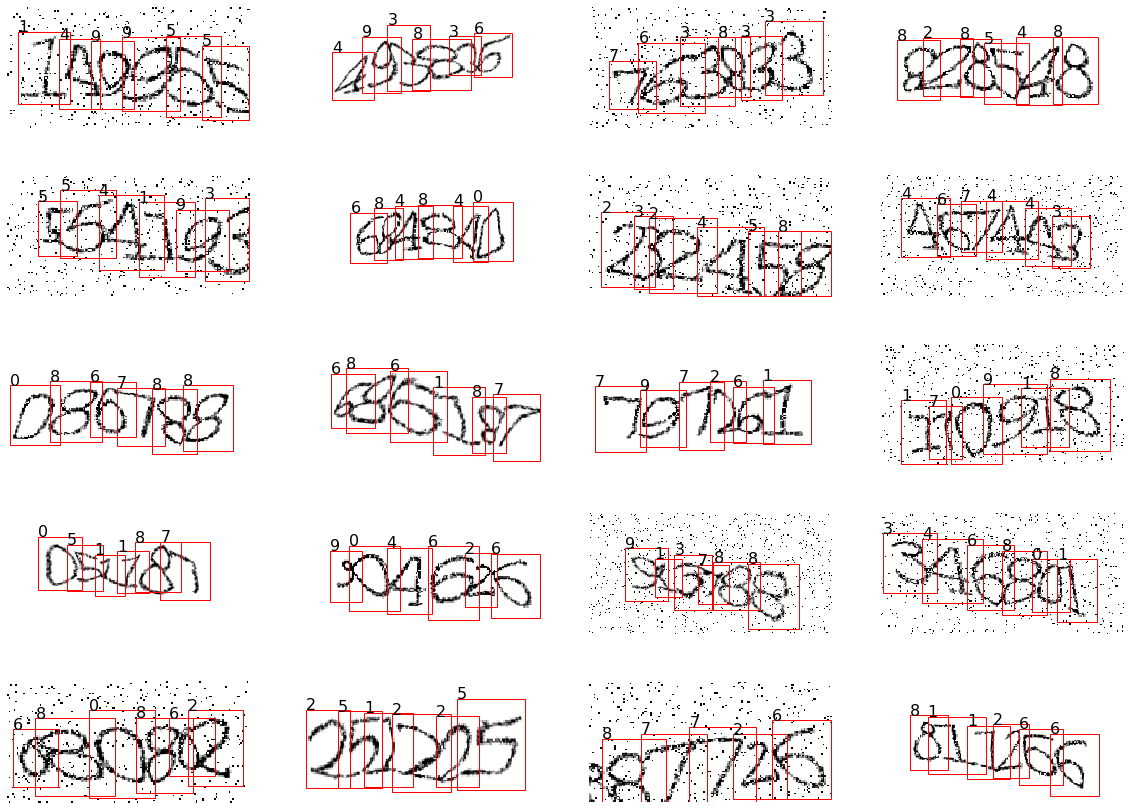

In [22]:
f, ax = plt.subplots(5, 4, figsize=(20, 15))

for i in range(20):
    img, targets = train_dataset[i]
    boxes, labels = targets['boxes'], targets['labels']
    
    img = img.squeeze().permute(1,2,0).numpy()
    boxes = boxes.numpy()
    labels = labels.numpy()
    
    r, c = i // 4, i % 4
    ax[r][c].imshow(img, cmap='gray')
    
    for (x0, y0, x1, y1), lbl in zip(boxes, labels):
        w, h = x1 - x0, y1 - y0
        rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax[r][c].add_patch(rect)
        ax[r][c].text(x0, y0, vocab.int2tok[lbl], fontsize=16)
        ax[r][c].axis('off')
plt.show()

## Training

In [31]:
def get_model(n_labels):
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_labels)
    
    return model

In [32]:
def train(model, loader, optimizer, epoch=None, lr_scheduler=None, batches_before_opt_step=1):
    model.train()
    
    if epoch: tqdm_text = f'Training {epoch} epoch'
    else:  tqdm_text = f'Training'
        
    epoch_loss = 0.
    cntr = 0
    for images, targets in tqdm(loader, desc=tqdm_text):
        cntr += 1
        images = [img.cuda() for img in images]
        targets = [{'boxes': t['boxes'].cuda(), 'labels': t['labels'].cuda()} for t in targets]
        
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        loss.backward()
        
        if cntr == batches_before_opt_step:
            cntr = 0
            optimizer.step()
            optimizer.zero_grad()
            
        
        if lr_scheduler:
            lr_scheduler.step()
            
        epoch_loss += loss.item()
        
    return epoch_loss / len(loader)


def evaluate(model, loader, epoch=None):
    # model has complicated set of losses so I wont calculate them myself
    # loss_dict is only returned in train mode thats why I use train mode
    # in evaluation function
    model.train()
    
    if epoch: tqdm_text = f'Evaluating {epoch} epoch'
    else:  tqdm_text = f'Evaluating'
    
    epoch_loss = 0.
    with torch.no_grad():
        for images, targets in tqdm(loader, desc=tqdm_text):
            
            images = [img.cuda() for img in images]
            targets = [{'boxes': t['boxes'].cuda(), 'labels': t['labels'].cuda()} for t in targets]
            
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            epoch_loss += loss.item()
        
    return epoch_loss / len(loader)

In [33]:
config = dict(
    epochs = 150,
    bs = 4,
)

vocab = Vocab(train_df)

train_dataset = CAPTCHADataset(join(path, 'train'), train_df, vocab, transforms)
val_dataset = CAPTCHADataset(join(path, 'val'), val_df, vocab, no_transform)

train_loader = DataLoader(train_dataset, config['bs'], collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, config['bs'], collate_fn=custom_collate)

In [34]:
model = get_model(len(vocab) + 1)
model.cuda()

param_groups = [
    {'params': model.backbone.body.conv1.parameters()},
    {'params': model.backbone.body.layer1.parameters()},
    {'params': model.backbone.body.layer2.parameters()},
    {'params': model.backbone.body.layer3.parameters()},
    {'params': model.backbone.body.layer4.parameters()},
    {'params': model.backbone.fpn.parameters()},
    {'params': model.rpn.head.parameters()},
    {'params': model.roi_heads.parameters()}
]

optimizer = torch.optim.RAdam(param_groups, lr=1e-3)

In [35]:
for group in optimizer.param_groups[:-1]:
    for param in group['params']:
        param.requires_grad = False
        
for param in optimizer.param_groups[-1]['params']:
    param.requires_grad = True

In [36]:
train_loss = train(model, train_loader, optimizer)
val_loss = evaluate(model, val_loader)

torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, 'models/final_faster_rcnn_fns_head.ptr')

print('train loss {:.4f}, val loss {:.4f}'.format(train_loss, val_loss))

Evaluating: 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

train loss 1.2680, val loss 0.9000


In [41]:
model.load_state_dict(torch.load('models/final_faster_rcnn_fns_head.ptr')['model_state_dict'])
optimizer.load_state_dict(torch.load('models/final_faster_rcnn_fns_head.ptr')['optimizer_state_dict'])

In [42]:
base_lr = 1e-3

def lr_update(n, base_lr):
    # epochs are counted from 0
    return base_lr * 0.7 ** n

for i, group in enumerate(optimizer.param_groups[::-1]):
    cur_lr = lr_update(i, base_lr)
    group['lr'] = cur_lr

In [43]:
for group in optimizer.param_groups:
    print(group['lr'])

8.235429999999997e-05
0.00011764899999999997
0.00016806999999999995
0.00024009999999999995
0.00034299999999999993
0.00049
0.0007
0.001


In [44]:
for param in model.parameters():
    param.requires_grad = True

In [45]:
best_loss = np.inf
no_improvement = 0
early_stop_cntr = 0
for epoch in range(200):
    
    train_loss = train(model, train_loader, optimizer, epoch=epoch+1)
    val_loss = evaluate(model, val_loader, epoch=epoch+1)
    
    if val_loss < best_loss:
        best_loss = val_loss
        no_improvement = 0
        early_stop_cntr = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, 'models/final_faster_rcnn.ptr')
    else:
        if no_improvement > 10:
            print('Lr decreased by 0.5')
            for group in optimizer.param_groups:
                group['lr'] = group['lr'] * 0.5
            no_improvement = 0
        elif early_stop_cntr > 25:
            print('Early stopped')
            print('{}: train loss {:.4f}, val loss {:.4f}'.format(epoch+1, train_loss, val_loss))
            break
        else:
            no_improvement += 1
            early_stop_cntr += 1
    
    print('{}: train loss {:.4f}, val loss {:.4f}'.format(epoch+1, train_loss, val_loss))

Training 2 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

1: train loss 0.7673, val loss 0.6090


Training 3 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

2: train loss 0.4902, val loss 0.3571


Training 4 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

3: train loss 0.3962, val loss 0.3597


Training 5 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

4: train loss 0.3577, val loss 0.3077


Training 6 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

5: train loss 0.3291, val loss 0.2869


Training 7 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

6: train loss 0.3004, val loss 0.3217


Training 8 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

7: train loss 0.2932, val loss 0.2830


Training 9 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

8: train loss 0.2958, val loss 0.2531


Training 10 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

9: train loss 0.2693, val loss 0.2469


Training 11 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

10: train loss 0.2644, val loss 0.2313


Training 12 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

11: train loss 0.2567, val loss 0.2552


Training 13 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

12: train loss 0.2518, val loss 0.2560


Training 14 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

13: train loss 0.2405, val loss 0.2055


Training 15 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

14: train loss 0.2392, val loss 0.2231


Training 16 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

15: train loss 0.2359, val loss 0.2121


Training 17 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

16: train loss 0.2490, val loss 0.2035


Training 18 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

17: train loss 0.2367, val loss 0.2162


Training 19 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

18: train loss 0.2370, val loss 0.2009


Training 20 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

19: train loss 0.2260, val loss 0.2454


Training 21 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

20: train loss 0.2356, val loss 0.1999


Training 22 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

21: train loss 0.2174, val loss 0.2281


Training 23 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

22: train loss 0.2167, val loss 0.1862


Training 24 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

23: train loss 0.2157, val loss 0.1872


Training 25 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

24: train loss 0.2152, val loss 0.2033


Training 26 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

25: train loss 0.2076, val loss 0.1832


Training 27 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

26: train loss 0.2158, val loss 0.2045


Training 28 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

27: train loss 0.2164, val loss 0.2198


Training 29 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

28: train loss 0.2052, val loss 0.2072


Training 30 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

29: train loss 0.2031, val loss 0.1809


Training 31 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

30: train loss 0.2180, val loss 0.2186


Training 32 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

31: train loss 0.2028, val loss 0.1948


Training 33 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

32: train loss 0.2116, val loss 0.2065


Training 34 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

33: train loss 0.2047, val loss 0.1942


Training 35 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

34: train loss 0.2033, val loss 0.1861


Training 36 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

35: train loss 0.2028, val loss 0.1961


Training 37 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

36: train loss 0.2107, val loss 0.1970


Training 38 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

37: train loss 0.2002, val loss 0.1877


Training 39 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

38: train loss 0.1976, val loss 0.1897


Training 40 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

39: train loss 0.2053, val loss 0.1990


Training 41 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

40: train loss 0.2113, val loss 0.1833


Training 42 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

Lr decreased by 0.5
41: train loss 0.1992, val loss 0.1845


Training 43 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

42: train loss 0.1887, val loss 0.1720


Training 44 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

43: train loss 0.1767, val loss 0.1808


Training 45 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

44: train loss 0.1785, val loss 0.1780


Training 46 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

45: train loss 0.1678, val loss 0.1576


Training 47 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

46: train loss 0.1722, val loss 0.1675


Training 48 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

47: train loss 0.1727, val loss 0.1706


Training 49 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

48: train loss 0.1652, val loss 0.1543


Training 50 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

49: train loss 0.1653, val loss 0.1561


Training 51 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

50: train loss 0.1664, val loss 0.1648


Training 52 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

51: train loss 0.1720, val loss 0.1586


Training 53 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

52: train loss 0.1739, val loss 0.1775


Training 54 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

53: train loss 0.1594, val loss 0.1642


Training 55 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

54: train loss 0.1647, val loss 0.1608


Training 56 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

55: train loss 0.1644, val loss 0.1657


Training 57 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

56: train loss 0.1677, val loss 0.1581


Training 58 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

57: train loss 0.1739, val loss 0.1908


Training 59 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

58: train loss 0.1629, val loss 0.1713


Training 60 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

59: train loss 0.1630, val loss 0.1681


Training 61 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

Lr decreased by 0.5
60: train loss 0.1731, val loss 0.1714


Training 62 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

61: train loss 0.1652, val loss 0.1550


Training 63 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

62: train loss 0.1621, val loss 0.1616


Training 64 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

63: train loss 0.1572, val loss 0.1659


Training 65 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

64: train loss 0.1468, val loss 0.1630


Training 66 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

65: train loss 0.1564, val loss 0.1655


Training 67 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

66: train loss 0.1556, val loss 0.1723


Training 68 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

67: train loss 0.1639, val loss 0.1662


Training 69 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

68: train loss 0.1586, val loss 0.1705


Training 70 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

69: train loss 0.1524, val loss 0.1623


Training 71 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

70: train loss 0.1551, val loss 0.1658


Training 72 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

71: train loss 0.1474, val loss 0.1690


Training 73 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

Lr decreased by 0.5
72: train loss 0.1450, val loss 0.1630


Training 74 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

73: train loss 0.1485, val loss 0.1511


Training 75 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

74: train loss 0.1451, val loss 0.1533


Training 76 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

75: train loss 0.1426, val loss 0.1530


Training 77 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

76: train loss 0.1424, val loss 0.1573


Training 78 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

77: train loss 0.1439, val loss 0.1504


Training 79 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

78: train loss 0.1413, val loss 0.1567


Training 80 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

79: train loss 0.1449, val loss 0.1513


Training 81 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

80: train loss 0.1385, val loss 0.1644


Training 82 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

81: train loss 0.1389, val loss 0.1564


Training 83 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

82: train loss 0.1407, val loss 0.1562


Training 84 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

83: train loss 0.1445, val loss 0.1623


Training 85 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

84: train loss 0.1344, val loss 0.1576


Training 86 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

85: train loss 0.1363, val loss 0.1544


Training 87 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

86: train loss 0.1347, val loss 0.1560


Training 88 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

87: train loss 0.1385, val loss 0.1491


Training 89 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

88: train loss 0.1434, val loss 0.1547


Training 90 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

89: train loss 0.1399, val loss 0.1486


Training 91 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

90: train loss 0.1382, val loss 0.1561


Training 92 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

91: train loss 0.1397, val loss 0.1642


Training 93 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

92: train loss 0.1437, val loss 0.1662


Training 94 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

93: train loss 0.1387, val loss 0.1600


Training 95 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

94: train loss 0.1317, val loss 0.1525


Training 96 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

95: train loss 0.1419, val loss 0.1675


Training 97 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

96: train loss 0.1395, val loss 0.1674


Training 98 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

97: train loss 0.1417, val loss 0.1570


Training 99 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

98: train loss 0.1346, val loss 0.1633


Training 100 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

99: train loss 0.1384, val loss 0.1579


Training 101 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

100: train loss 0.1317, val loss 0.1623


Training 102 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

Lr decreased by 0.5
101: train loss 0.1373, val loss 0.1570


Training 103 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

102: train loss 0.1352, val loss 0.1513


Training 104 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

103: train loss 0.1271, val loss 0.1519


Training 105 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

104: train loss 0.1304, val loss 0.1513


Training 106 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

105: train loss 0.1289, val loss 0.1494


Training 107 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

106: train loss 0.1360, val loss 0.1501


Training 108 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

107: train loss 0.1386, val loss 0.1524


Training 109 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

108: train loss 0.1286, val loss 0.1532


Training 110 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

109: train loss 0.1291, val loss 0.1581


Training 111 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

110: train loss 0.1296, val loss 0.1585


Training 112 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

111: train loss 0.1333, val loss 0.1614


Training 113 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

112: train loss 0.1234, val loss 0.1608


Training 114 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

Lr decreased by 0.5
113: train loss 0.1361, val loss 0.1607


Training 115 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

114: train loss 0.1349, val loss 0.1562


Training 116 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

115: train loss 0.1209, val loss 0.1528


Training 117 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

116: train loss 0.1282, val loss 0.1515


Training 118 epoch:   0%|          | 0/68 [00:00<?, ?it/s]

117: train loss 0.1303, val loss 0.1534


Evaluating 118 epoch: 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

Early stopped
118: train loss 0.1232, val loss 0.1498


# Predictions

In [46]:
def get_prediction(img_path, model, threshold):
    img = plt.imread(img_path)[:,:,:3]
    img = torch.FloatTensor(img).permute(2,0,1).cuda()
    pred = model([img])
    pred_class = [vocab.int2tok[i] for i in list(pred[0]['labels'].detach().cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
    return pred_boxes, pred_class, pred_score

In [47]:
model = get_model(len(vocab) + 1)
model.cuda();

In [48]:
model.load_state_dict(torch.load('models/final_faster_rcnn.ptr')['model_state_dict'])

<All keys matched successfully>

In [49]:
model.eval();

In [50]:
test_images = listdir(join(path, 'captchas_unlabeled'))

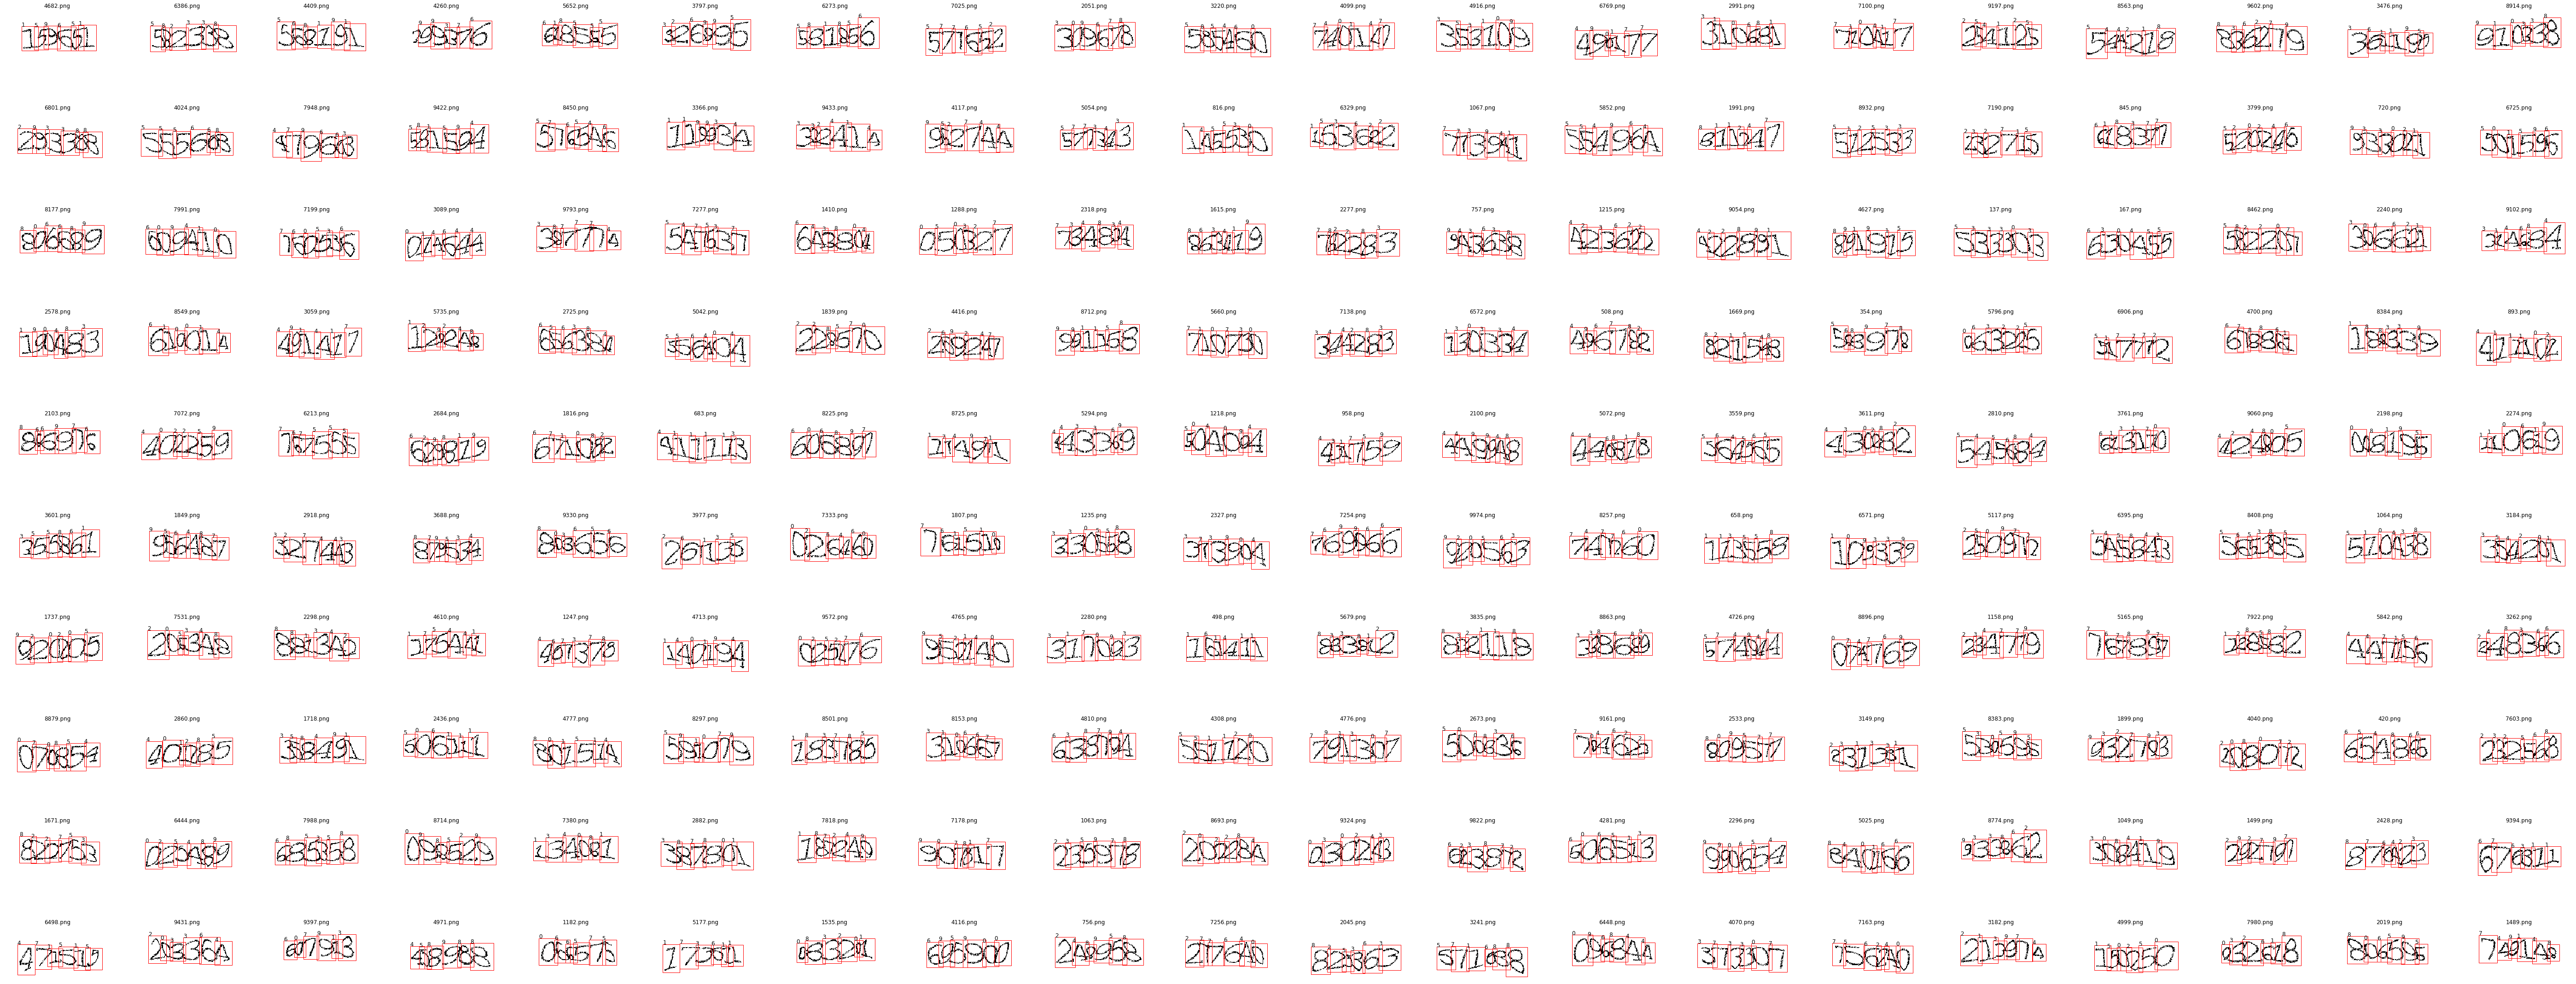

In [63]:
cntr = 0
threshold = 0.9

# Create figure and axes
fig,ax = plt.subplots(10, 20, figsize=(100, 40))

_path = join(path, 'captchas_unlabeled')
for name in test_images[:200]:
    full_name = join(_path, name)
    pred = get_prediction(full_name, model, threshold)
    im = Image.open(full_name) 

    row, col = cntr // 20, cntr % 20
    # Display the image
    ax[row, col].imshow(im)

    # Create a Rectangle patch
    cntr_1 = 0
    for ((x0, y0), (x1, y1)), letter, score in zip(pred[0], pred[1], pred[2]):
        if cntr_1 == 6:
            cntr_1 = 0
            break
        w, h = x1 - x0, y1 - y0
        rect = patches.Rectangle((x0,y0),w,h,linewidth=1,edgecolor='r',facecolor='none')
        score = '{:.2f}'.format(score)
        ax[row, col].text(x0, y0, f'{letter}', fontsize=12)
        ax[row, col].add_patch(rect)
        ax[row, col].set_title(name)
        cntr_1 += 1
    
    ax[row, col].axis('off')
    cntr += 1
fig.savefig('/home/egor/job/CAPTCHA_recognition/performance/200preds_10_20.jpg')
# plt.show()